In [65]:
%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [66]:
import matplotlib.pyplot as plt 
import seaborn as sns
import pandas as pd 
import numpy as np
import os
import json
from collections import defaultdict

from scipy.stats import spearmanr, pearsonr

from regmixer.synthesize_mixture import calculate_priors
from regmixer.utils import config_from_path
from regmixer.eval.utils import (
    build_regression,
    get_output_dir,
    get_runs_from_api,
    mk_run_from_json,
    mk_run_metrics,
    mk_weights_from_config,
    mk_output_prefix,
    plot_correlation,
    #plot_weights,
    #simulate,
    simulate2,
    )

from regmixer.eval.constants import (
    WandbMetrics,
    ObjectiveWeights,
)


import pathlib
import wandb


from regmixer.eval.constants import GroupedWandbMetrics


from regmixer.eval.law import ScalingLaw

In [69]:
def load_X_Y(experiment_groups, group_metrics, workspace, experiment_group_name, priors):
    BASE_CACHE_DIR = "cache/"

    if experiment_group_name is None:
        experiment_group_name = "_".join(experiment_groups)
        
    cache_path = pathlib.Path(BASE_CACHE_DIR) / f"{experiment_group_name}_runs_cache.json"
    api = wandb.Api() 

    num_samples=1

    eval_metric_group = GroupedWandbMetrics[group_metrics]
    eval_metric_group_name = group_metrics

    run_instances = get_runs_from_api(
            api, workspace, experiment_groups, cache_path, True, num_samples, eval_metric_group
        )
    
            
    run_ratios = [
            {"run": run.id, "name": run.display_name, "index": idx, **mk_weights_from_config(run.config, priors)}
            for idx, run in enumerate(run_instances)
        ]
    

    run_metrics = []
    for idx, run in enumerate(run_instances):
        if len(run.samples) == 0:
            print("????")
            print(run.display_name)
            continue 
        entry =    {
            "run": run.id,
            "name": run.display_name,
            "index": idx,
            **mk_run_metrics(
                history=run.samples,
                samples=num_samples,
                metrics=(eval_metric_group_name, eval_metric_group.value),
                display_name=run.display_name,
                average=False,
            ),
        }
        run_metrics.append(entry)

    ratios = pd.DataFrame(run_ratios)
    metrics = pd.DataFrame(run_metrics)
    ratios = ratios[ratios['run'].isin(metrics.run)]


    return ratios,  metrics


In [70]:
config = "src/regmixer/config/dclm-larger-datadelve-5xC-30m.yaml"
launch_config = config_from_path(config)


priors = calculate_priors(
        source_configs=launch_config.sources,
        dtype=launch_config.dtype,
        use_cache=True,
    )

2025-06-01 19:36:12,736 - regmixer.synthesize_mixture - INFO - Source distribution cache found, using cached values! This can be disabled by setting use_cache=False.


# Visualize proposed mixes

In [61]:
path_to_run = {
    "output/62e7dc06/sweep_repetition_factor/92505c8b3fd3ab66": "repeat_1",
    "output/62e7dc06/sweep_repetition_factor/a65af40ea2ea76d0": "repeat_1.5",
    "output/62e7dc06/sweep_repetition_factor/e3ed9b14d33feed6": "repeat_2",
    "output/62e7dc06/sweep_repetition_factor/db051353f9a4d4d4": "repeat_2.5",
    "output/62e7dc06/sweep_repetition_factor/4113da3abcb0ae41": "repeat_3",
    "output/62e7dc06/sweep_repetition_factor/84c602b4b76501d3": "repeat_3.5",
    "output/62e7dc06/sweep_repetition_factor/2399d0b2a9b887d1": "repeat_4",
    "output/62e7dc06/sweep_repetition_factor/b47f79ea2d467c65": "repeat_4.5",
    "output/62e7dc06/sweep_repetition_factor/9ace14c447683dc1": "repeat_5",
    
}

In [62]:
all_ratios = {}

for folder, run_type in path_to_run.items():
    full_path = folder 

    files = os.listdir(full_path)
    for file in files:
        if file.endswith("optimal.json"):
            full_path = os.path.join(folder, file)
            break

    with open(full_path, "r") as f:
        ratios = json.load(f)

    all_ratios[run_type] = ratios

In [63]:
natural = {'adult_content': 0.013552015640753739,
 'art_and_design': 0.014131942399105356,
 'crime_and_law': 0.03402618295594812,
 'education_and_jobs': 0.036938158572321196,
 'electronics_and_hardware': 0.016033708349045165,
 'entertainment': 0.08835361235206982,
 'fashion_and_beauty': 0.007451307902511114,
 'finance_and_business': 0.06206278551627001,
 'food_and_dining': 0.02118745993746211,
 'games': 0.04599849834056857,
 'health': 0.07869924556724804,
 'history_and_geography': 0.03220994389194089,
 'home_and_hobbies': 0.025382155462877018,
 'industrial': 0.008714428090097422,
 'literature': 0.07296686896975939,
 'politics': 0.12223962603857506,
 'religion': 0.055555385841762644,
 'science_math_and_technology': 0.0854262108683093,
 'social_life': 0.04374636822484258,
 'software': 0.021607876004248874,
 'software_development': 0.044676994856554464,
 'sports_and_fitness': 0.039351999871120806,
 'transportation': 0.018158661240478786,
 'travel_and_tourism': 0.011528563106129541}

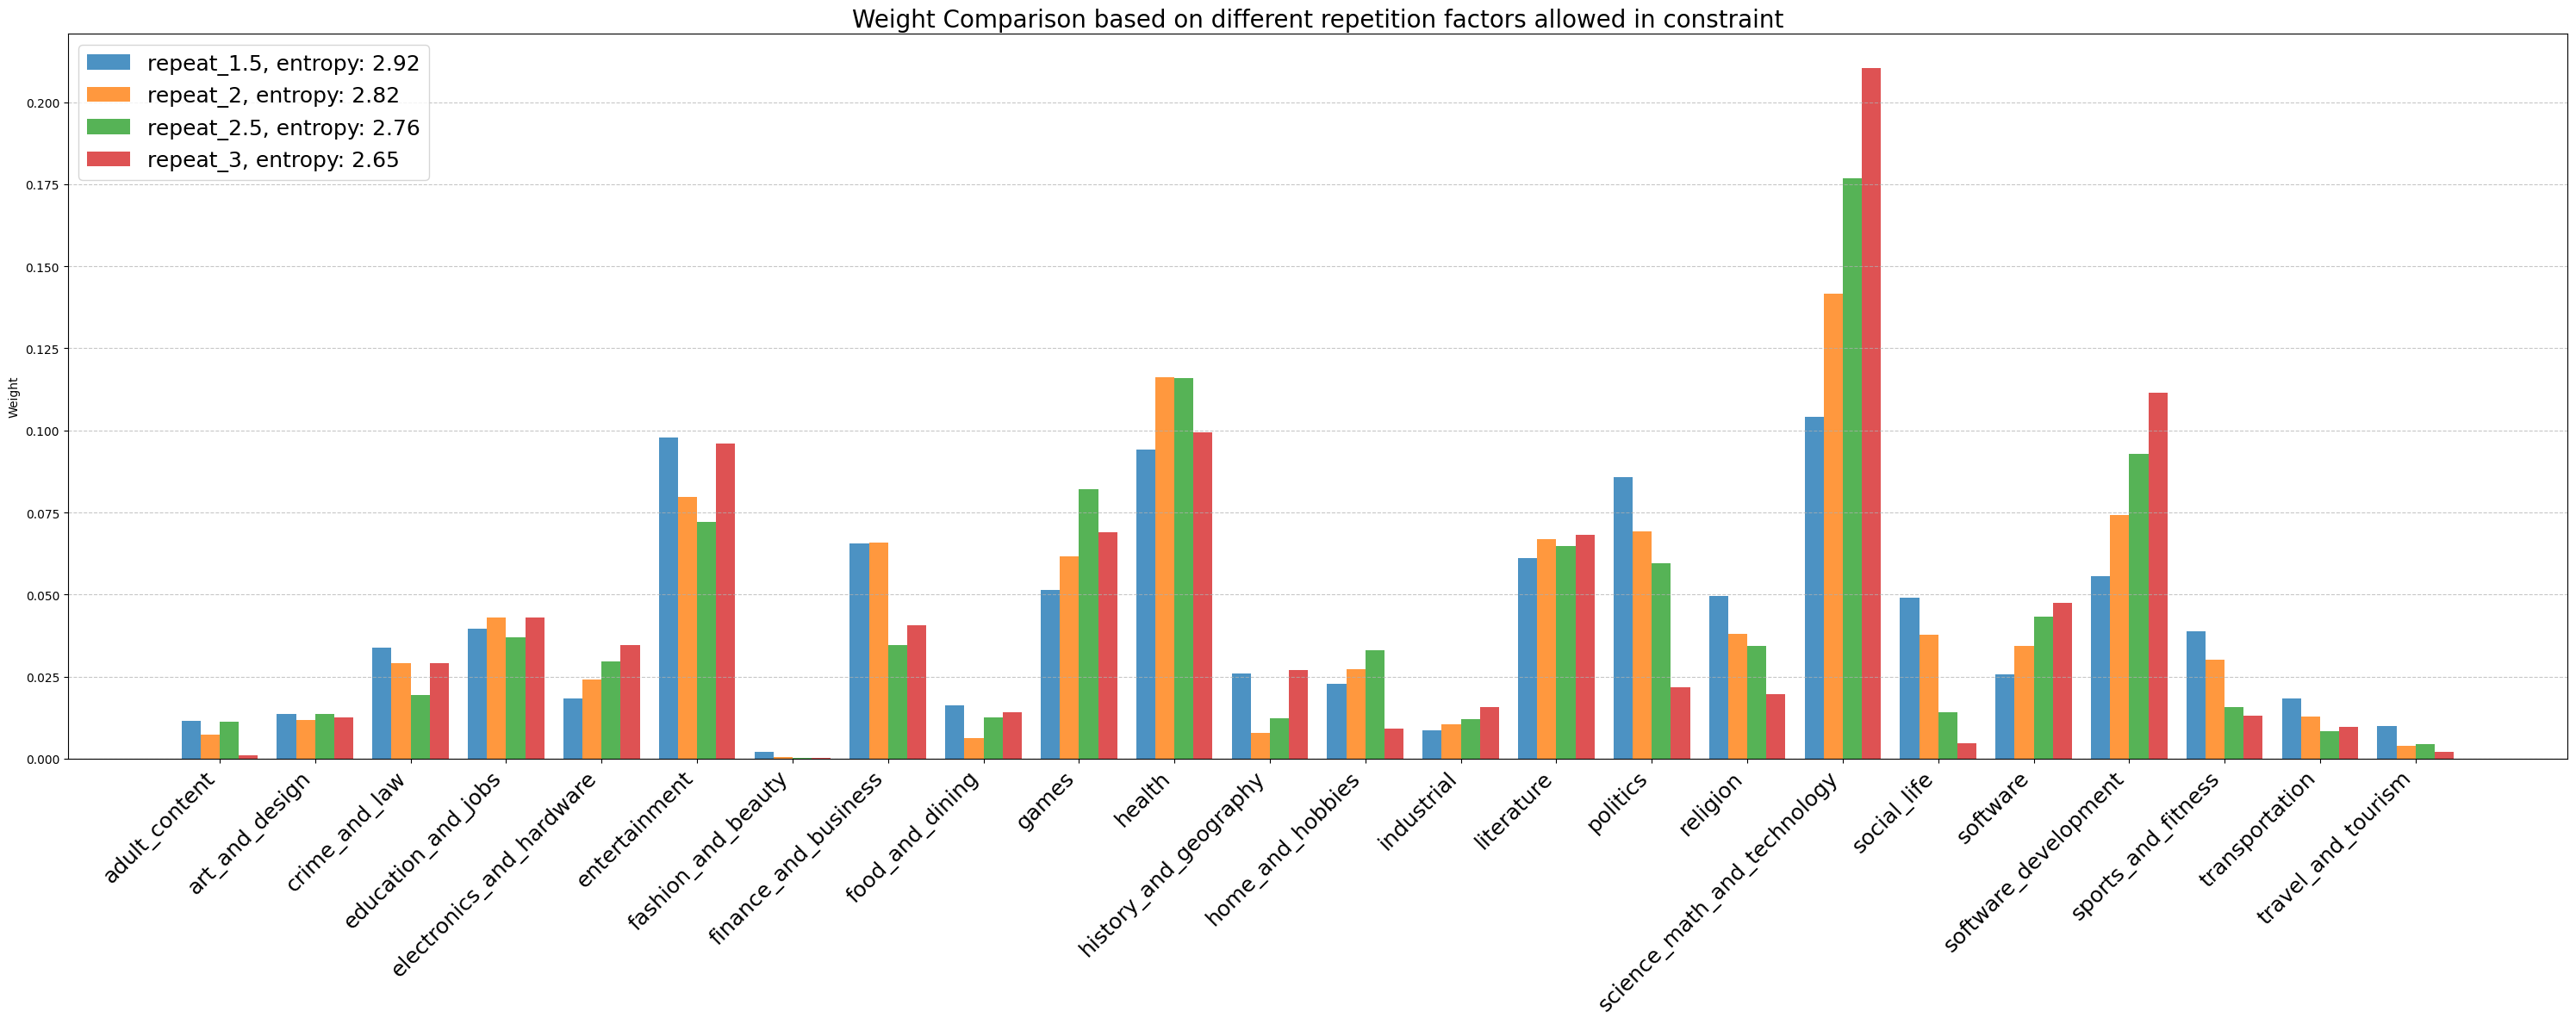

In [64]:
import matplotlib.pyplot as plt
import numpy as np

def entropy(p):
    p = np.asarray(p)
    p = p[p > 0]  # Remove zero entries to avoid log(0)
    return -np.sum(p * np.log(p))  # natural log


# Extract domains in a consistent order
domains = [entry['domain'] for entry in all_ratios['repeat_3']]
x = np.arange(len(domains))  # group positions

# Filter methods
methods_to_plot = [
    method for method in all_ratios if method not in ["repeat_5", "repeat_4.5", "repeat_4", "repeat_3.5", "repeat_1"]
]

# Add 'natural' as a pseudo-method
#methods_to_plot.append('natural')

# Prepare bar width
num_methods = len(methods_to_plot)
bar_width = 0.8 / num_methods

plt.figure(figsize=(30, 12))

for i, method in enumerate(methods_to_plot):
    if method == 'natural':
        weights = [natural.get(domain, 0) for domain in domains]
    else:
        weights = [entry['weight'] for entry in all_ratios[method]]

    offset = (i - num_methods / 2) * bar_width + bar_width / 2

    mix_entropy = entropy(weights)

    if method == 'natural':
        bars = plt.bar(x + offset, weights, width=bar_width, alpha=0.8, label=f"{method}, entropy: {mix_entropy:.2f}", hatch='//')
    else:
        bars = plt.bar(x + offset, weights, width=bar_width, alpha=0.8, label=f"{method}, entropy: {mix_entropy:.2f}")

    

    """for bar in bars:
        height = bar.get_height()
        if height > 0:
            plt.text(
                bar.get_x() + bar.get_width() / 2,
                height*1.1,
                f"{height:.2e}" if height < 1e-2 else f"{height:.3f}",
                ha='center',
                va='bottom',
                fontsize=8,
                rotation=90
            )"""

# Plot formatting
plt.xticks(ticks=x, labels=domains, rotation=45, ha='right', fontsize=18)
plt.ylabel('Weight')
#plt.yscale("log")
plt.title('Weight Comparison based on different repetition factors allowed in constraint', size=20)
plt.legend(loc="upper left", fontsize=18)
plt.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.show()


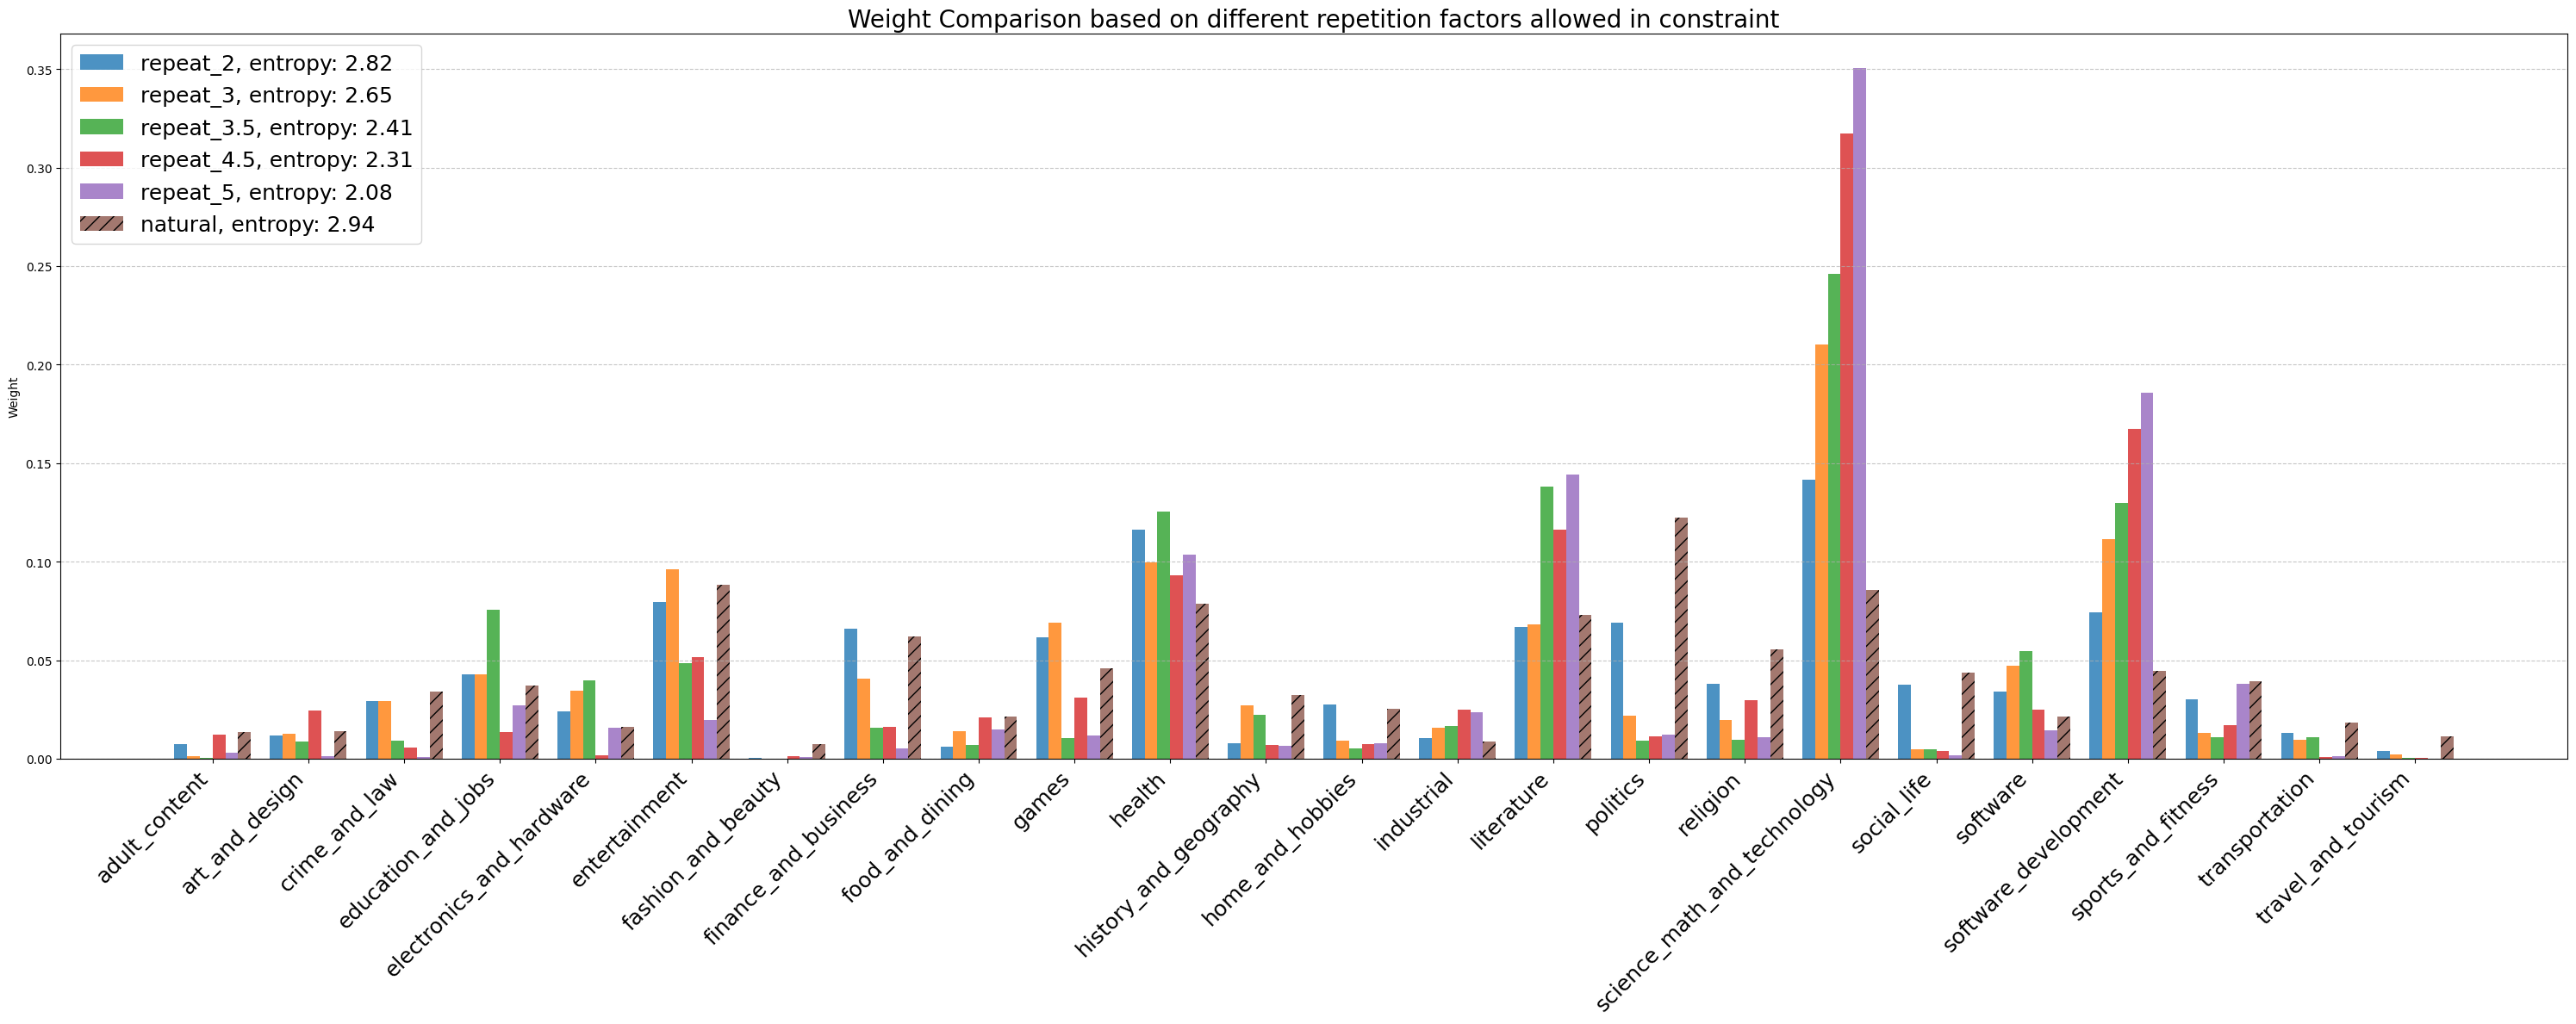

In [160]:
import matplotlib.pyplot as plt
import numpy as np

def entropy(p):
    p = np.asarray(p)
    p = p[p > 0]  # Remove zero entries to avoid log(0)
    return -np.sum(p * np.log(p))  # natural log


# Extract domains in a consistent order
domains = [entry['domain'] for entry in all_ratios['repeat_1']]
x = np.arange(len(domains))  # group positions

# Filter methods
methods_to_plot = [
    method for method in all_ratios if method in ["repeat_2", "repeat_3", "repeat_3.5", "repeat_4.5", "repeat_5"]# if method not in ["repeat_5", "repeat_4.5", "repeat_4", "repeat_3.5", "repeat_1"]
]

# Add 'natural' as a pseudo-method
methods_to_plot.append('natural')

# Prepare bar width
num_methods = len(methods_to_plot)
bar_width = 0.8 / num_methods

plt.figure(figsize=(30, 12))

for i, method in enumerate(methods_to_plot):
    if method == 'natural':
        weights = [natural.get(domain, 0) for domain in domains]
    else:
        weights = [entry['weight'] for entry in all_ratios[method]]

    offset = (i - num_methods / 2) * bar_width + bar_width / 2

    mix_entropy = entropy(weights)

    if method == 'natural':
        bars = plt.bar(x + offset, weights, width=bar_width, alpha=0.8, label=f"{method}, entropy: {mix_entropy:.2f}", hatch='//')
    else:
        bars = plt.bar(x + offset, weights, width=bar_width, alpha=0.8, label=f"{method}, entropy: {mix_entropy:.2f}")

    

    """for bar in bars:
        height = bar.get_height()
        if height > 0:
            plt.text(
                bar.get_x() + bar.get_width() / 2,
                height*1.1,
                f"{height:.2e}" if height < 1e-2 else f"{height:.3f}",
                ha='center',
                va='bottom',
                fontsize=8,
                rotation=90
            )"""

# Plot formatting
plt.xticks(ticks=x, labels=domains, rotation=45, ha='right', fontsize=18)
plt.ylabel('Weight')
#plt.yscale("log")
plt.title('Weight Comparison based on different repetition factors allowed in constraint', size=20)
plt.legend(loc="upper left", fontsize=18)
plt.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.show()


# 1B pareto improvements

In [145]:
experiment_groups = ["c24744d0",
                     "173bec67",
                     "4557a88b",
                     "b9e80c0a",
                     "e07ba770",
                     "28f8e9a9",
                     "b79f5bcf"
                     ]

group_metrics = 'all_bpb_with_offline_extended_v2'
workspace = "ai2-llm/olmo-cookbook"
ratios, metrics = load_X_Y(experiment_groups, group_metrics, workspace, None, priors)

2025-06-01 21:53:39,956 - regmixer.eval.utils - WARNING - Run dclm-1b-log-linear-extended-eval-constrain-obj-c24744d0 has crashed; still using its final result
2025-06-01 21:53:39,960 - regmixer.eval.utils - WARNING - Run dclm-1b-log-linear-full-eval-constrain-obj-pareto-with-predicted-scores-173bec67 has crashed; still using its final result
2025-06-01 21:53:39,964 - regmixer.eval.utils - WARNING - Run dclm-1b-log-linear-full-eval-corr-weighting-constrain-obj-pareto-with-predicted-scores-b9e80c0a has crashed; still using its final result
2025-06-01 21:53:39,967 - regmixer.eval.utils - WARNING - Run dclm-1b-log-linear-full-eval-corr-weighting-constrain-obj-pareto-with-true-scores-e07ba770 has crashed; still using its final result


In [146]:
experiment_groups = ["d7eaca81",
                     "357a137e"
                     ]

group_metrics = 'all_bpb_with_basic_skills_in_loop'
workspace = "ai2-llm/olmo-cookbook"
extra_ratios, extra_metrics = load_X_Y(experiment_groups, group_metrics, workspace, None, priors)

cols = [
    'eval/downstream/basic_skills_string_operations_rc_5shot (BPB v2)',
    'eval/downstream/basic_skills_pattern_rc_5shot (BPB v2)',
    'eval/downstream/basic_skills_logical_reasoning_rc_5shot (BPB v2)',
    'eval/downstream/basic_skills_common_knowledge_rc_5shot (BPB v2)',
    'eval/downstream/basic_skills_coding_rc_5shot (BPB v2)',
    'eval/downstream/basic_skills_arithmetic_rc_5shot (BPB v2)',
]

# Rename logic
def rename_column(col):
    # Strip the prefix and suffix
    core = col.replace('eval/downstream/', '').replace('_rc_5shot (BPB v2)', '')
    return f"{core}:rc::olmes"

# Create a rename dictionary
rename_dict = {col: rename_column(col) for col in cols}

# Suppose you have a DataFrame `df`
extra_metrics = extra_metrics.rename(columns=rename_dict)

2025-06-01 21:53:56,850 - regmixer.eval.utils - WARNING - Run dclm-1b-log-linear-full-eval-constrain-obj-pareto-with-predicted-scores-357a137e has crashed; still using its final result


In [147]:
metrics = pd.concat([metrics, extra_metrics])
ratios = pd.concat([ratios, extra_ratios])

In [148]:
metrics['avg_bpb'] = metrics[metrics.columns[3:57]].mean(axis=1)

In [149]:
desc_to_name = {
    'natural': 'olmo-cookbook-core-v2-1bv2-5xC-dclm-baseline-topic-classified-sample-natural-28f8e9a9',
    'no-pareto': 'dclm-1b-log-linear-extended-eval-constrain-obj-c24744d0',
    'offline-correlation-weighting-olmo2-dense': 'dclm-offline-correlation-weighting-from-dense-olmo2-b79f5bcf',
    'pareto-predicted': 'dclm-1b-log-linear-full-eval-constrain-obj-pareto-with-predicted-scores-173bec67',
    'pareto-true': 'dclm-1b-log-linear-full-eval-constrain-obj-pareto-with-true-scores-4557a88b',
    'pareto-predicted-corr': 'dclm-1b-log-linear-full-eval-corr-weighting-constrain-obj-pareto-with-predicted-scores-b9e80c0a',
    'pareto-true-corr': 'dclm-1b-log-linear-full-eval-corr-weighting-constrain-obj-pareto-with-true-scores-e07ba770',
    'pareto-predicted-repeat-2': 'dclm-1b-log-linear-full-eval-constrain-obj-pareto-with-predicted-scores-d7eaca81',
    'pareto-predicted-repeat-3': 'dclm-1b-log-linear-full-eval-constrain-obj-pareto-with-predicted-scores-357a137e'
}

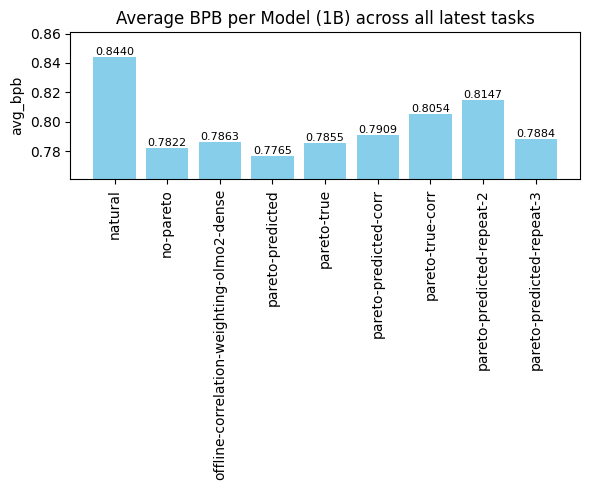

In [150]:
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

labels = list(desc_to_name.keys())
values = [metrics[metrics.name == name]['avg_bpb'].values[0] for desc, name in desc_to_name.items()]

# Assign colors (can customize later)
colors = ["skyblue" for _ in labels]

fig, ax = plt.subplots(figsize=(6, 5))

# Plot bars
bars = ax.bar(labels, values, color=colors)
ax.set_ylabel("avg_bpb")
ax.set_title("Average BPB per Model (1B) across all latest tasks")
ax.set_xticks(range(len(labels)))
ax.set_xticklabels(labels, rotation=90)
ax.set_ylim(min(values) * 0.98, max(values) * 1.02)
plt.tight_layout()

# Add value labels on top of each bar
for bar, value in zip(bars, values):
    height = bar.get_height()
    ax.text(
        bar.get_x() + bar.get_width() / 2,
        height,
        f"{value:.4f}",       # format as needed (e.g., .2f or .3f)
        ha='center',
        va='bottom',
        fontsize=8
    )

plt.show()



<Figure size 1400x600 with 0 Axes>

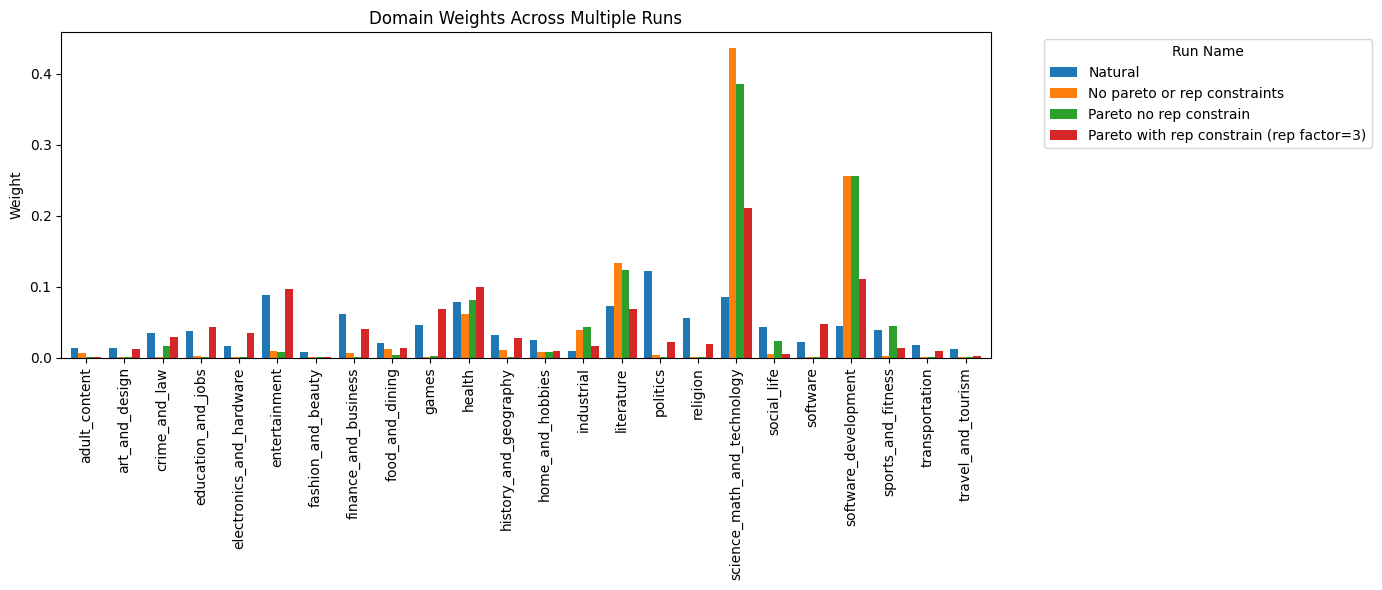

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Mapping from original run names to desired legend labels
label_map = {
    'olmo-cookbook-core-v2-1bv2-5xC-dclm-baseline-topic-classified-sample-natural-28f8e9a9': 'Natural',
    'dclm-1b-log-linear-extended-eval-constrain-obj-c24744d0': 'No pareto or rep constraints',
    'dclm-1b-log-linear-full-eval-constrain-obj-pareto-with-predicted-scores-357a137e': 'Pareto with rep constrain (rep factor=3)',
    'dclm-1b-log-linear-full-eval-constrain-obj-pareto-with-predicted-scores-173bec67': 'Pareto without rep constrain',
}

# Filter and rename
subset = ratios[ratios['name'].isin(label_map.keys())].copy()
subset['name'] = subset['name'].map(label_map)

subset.sort_values(by='name', inplace=True)

# Prepare weights for plotting
domain_columns = [col for col in ratios.columns if col not in ['run', 'name', 'index']]
weights_df = subset.set_index('name')[domain_columns]

# Transpose for plotting
plot_df = weights_df.T


# Plot
plt.figure(figsize=(14, 6))
plot_df.plot(kind='bar', figsize=(14, 6), width=0.8)
plt.xticks(rotation=90)
plt.ylabel("Weight")
plt.title("Domain Weights Across Multiple Runs")
plt.legend(title="Run Name", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


# Examine pareto improvements

First, compare natural distr vs a mix optimized without pareto improvements

0.2570391891445636 -0.18495195859509983 0.061752149003789794 19


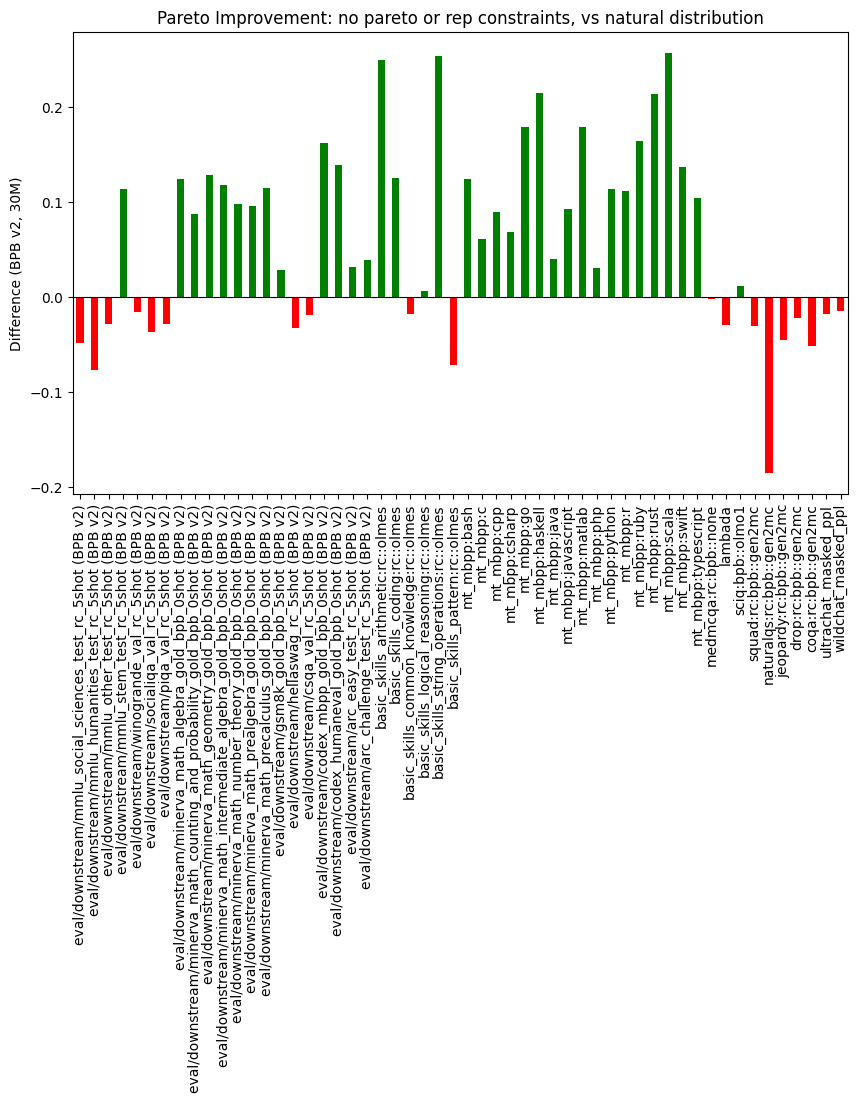

In [189]:
import pandas as pd
import matplotlib.pyplot as plt

# Load your DataFrame (assuming it's already in a variable called `metrics`)
# Example setup:
# metrics = pd.read_csv('your_file.csv') or metrics = ...

# Step 1: Identify the reference and target model
reference_name = 'olmo-cookbook-core-v2-1bv2-5xC-dclm-baseline-topic-classified-sample-natural-28f8e9a9'  # adjust as needed
target_name = 'dclm-1b-log-linear-extended-eval-constrain-obj-c24744d0'

# Step 2: Set index for easy lookup
metrics_indexed = metrics.set_index('name')

# Step 3: Get task columns (excluding name or metadata)
task_columns = metrics.columns[3:57]

# Step 4: Compute differences
reference = metrics_indexed.loc[reference_name, task_columns]
target = metrics_indexed.loc[target_name, task_columns]
diff =  reference - target 

print(diff.max(), diff.min(), diff.mean(), np.where(diff < 0)[0].shape[0])

# Step 5: Plot
colors = ['green' if val > 0 else 'red' for val in diff]
plt.figure(figsize=(10, 6))
diff.plot(kind='bar', color=colors)
plt.title(f'Pareto Improvement: no pareto or rep constraints, vs natural distribution')
plt.ylabel('Difference (BPB v2, 30M)')
plt.axhline(0, color='black', linewidth=0.8)
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


0.3020501310817776 -0.25487128484041377 0.05765833304262681 17


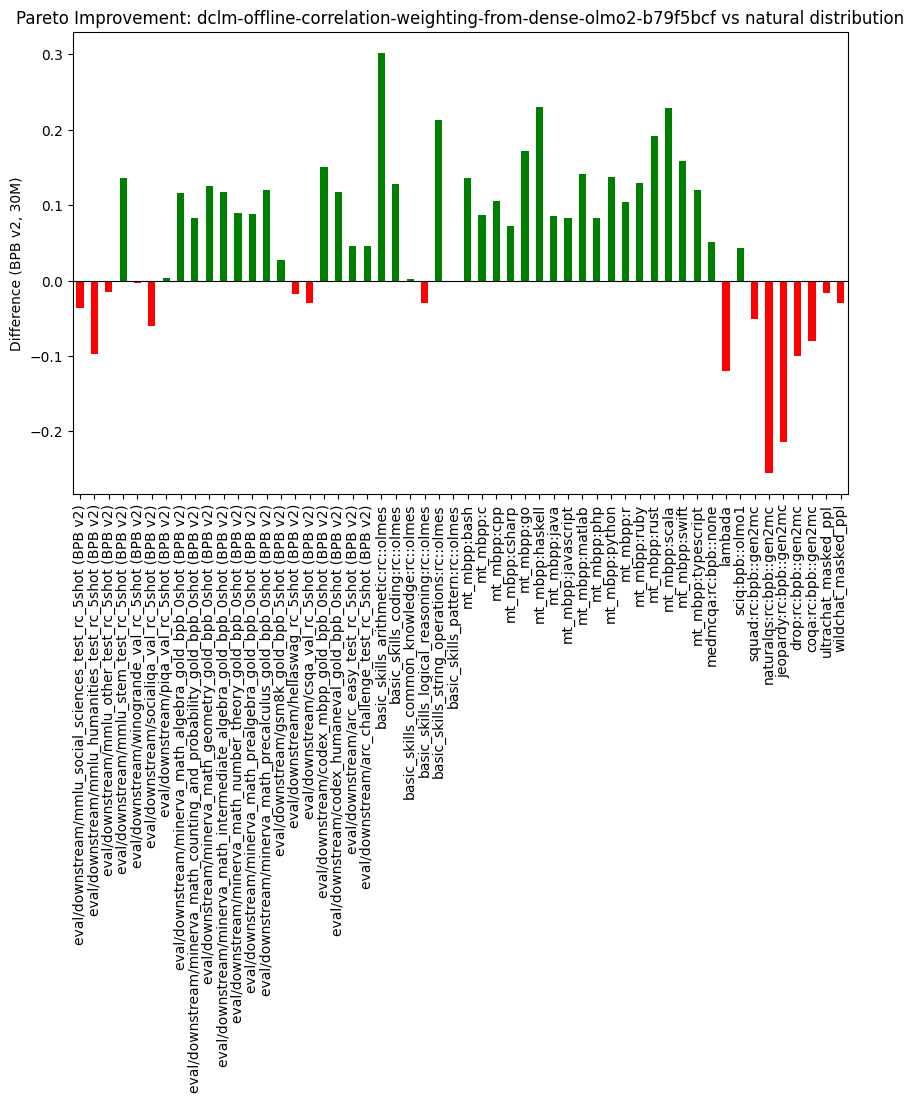

In [162]:
import pandas as pd
import matplotlib.pyplot as plt

# Load your DataFrame (assuming it's already in a variable called `metrics`)
# Example setup:
# metrics = pd.read_csv('your_file.csv') or metrics = ...

# Step 1: Identify the reference and target model
reference_name = 'olmo-cookbook-core-v2-1bv2-5xC-dclm-baseline-topic-classified-sample-natural-28f8e9a9'  # adjust as needed
target_name = 'dclm-offline-correlation-weighting-from-dense-olmo2-b79f5bcf'

# Step 2: Set index for easy lookup
metrics_indexed = metrics.set_index('name')

# Step 3: Get task columns (excluding name or metadata)
task_columns = metrics.columns[3:57]

# Step 4: Compute differences
reference = metrics_indexed.loc[reference_name, task_columns]
target = metrics_indexed.loc[target_name, task_columns]
diff =  reference - target 

print(diff.max(), diff.min(), diff.mean(), np.where(diff < 0)[0].shape[0])

# Step 5: Plot
colors = ['green' if val > 0 else 'red' for val in diff]
plt.figure(figsize=(10, 6))
diff.plot(kind='bar', color=colors)
plt.title(f'Pareto Improvement: {target_name} vs natural distribution')
plt.ylabel('Difference (BPB v2, 30M)')
plt.axhline(0, color='black', linewidth=0.8)
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


Compare natural distribution vs pareto with predicted scores 

0.3731814836201539 -0.18694208258749168 0.06753556025844795 20


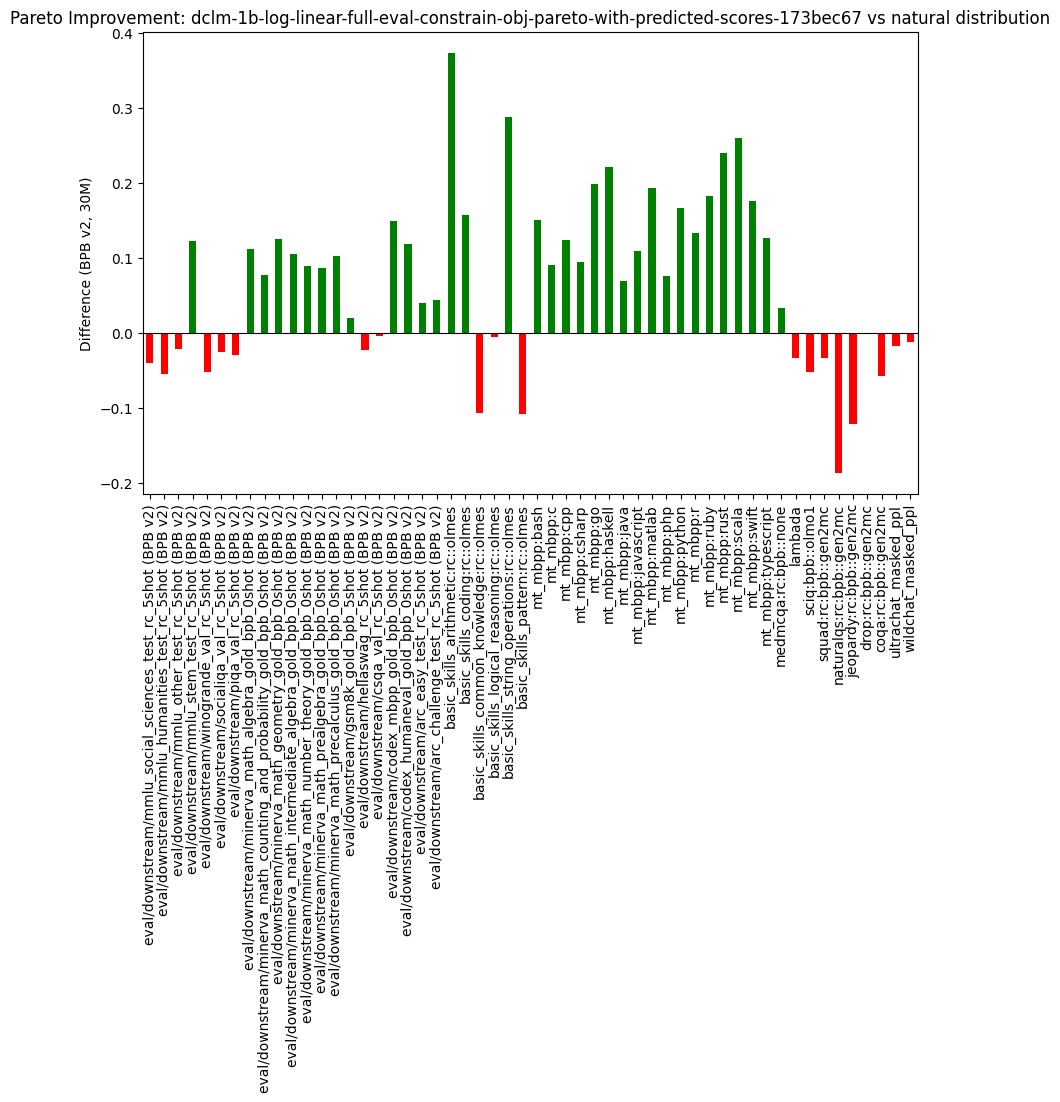

In [163]:
import pandas as pd
import matplotlib.pyplot as plt

# Load your DataFrame (assuming it's already in a variable called `metrics`)
# Example setup:
# metrics = pd.read_csv('your_file.csv') or metrics = ...

# Step 1: Identify the reference and target model
reference_name = 'olmo-cookbook-core-v2-1bv2-5xC-dclm-baseline-topic-classified-sample-natural-28f8e9a9'  # adjust as needed
target_name = 'dclm-1b-log-linear-full-eval-constrain-obj-pareto-with-predicted-scores-173bec67'

# Step 2: Set index for easy lookup
metrics_indexed = metrics.set_index('name')

# Step 3: Get task columns (excluding name or metadata)
task_columns = metrics.columns[3:57]

# Step 4: Compute differences
reference = metrics_indexed.loc[reference_name, task_columns]
target = metrics_indexed.loc[target_name, task_columns]
diff =  reference - target 

print(diff.max(), diff.min(), diff.mean(), np.where(diff < 0)[0].shape[0])

# Step 5: Plot
colors = ['green' if val > 0 else 'red' for val in diff]
plt.figure(figsize=(10, 6))
diff.plot(kind='bar', color=colors)
plt.title(f'Pareto Improvement: {target_name} vs natural distribution')
plt.ylabel('Difference (BPB v2, 30M)')
plt.axhline(0, color='black', linewidth=0.8)
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


0.24402103431972 -0.07558242684064509 0.05844649344346528 19


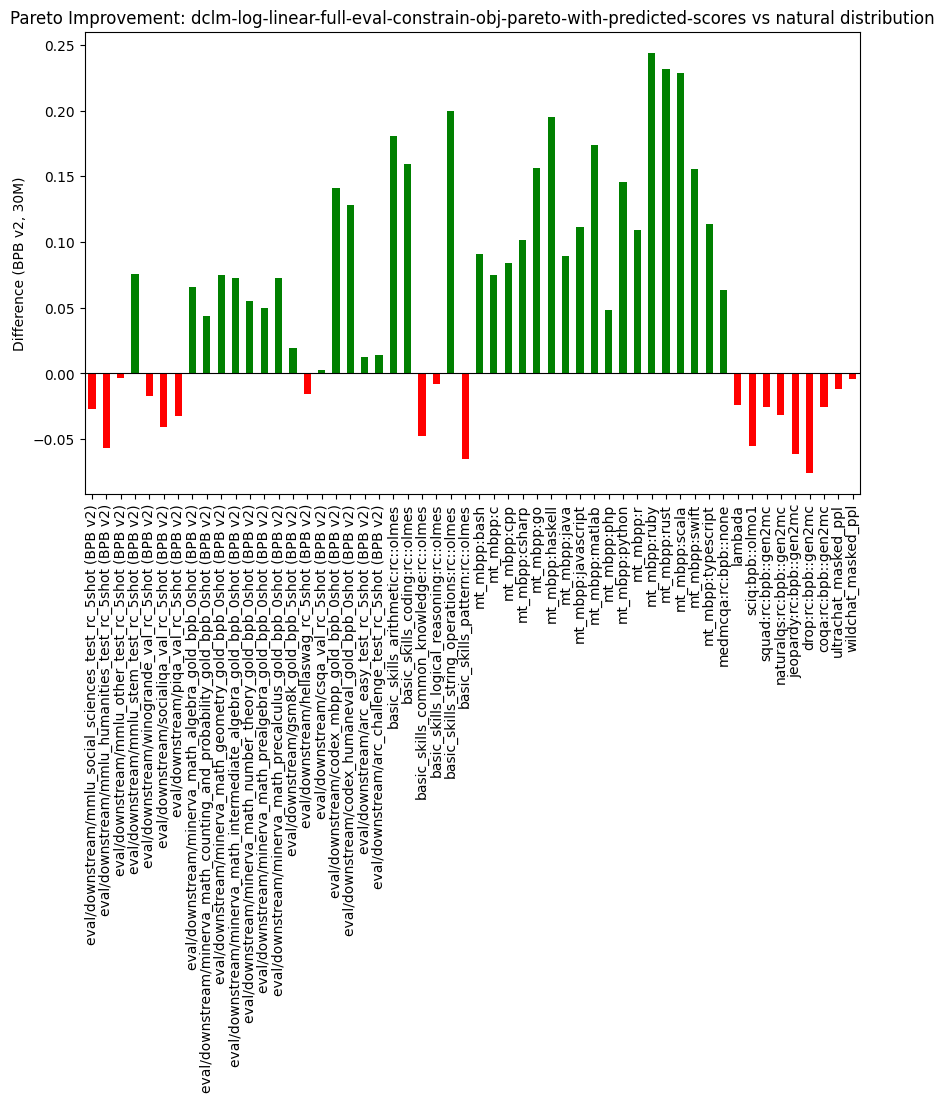

In [139]:
import pandas as pd
import matplotlib.pyplot as plt

# Load your DataFrame (assuming it's already in a variable called `metrics`)
# Example setup:
# metrics = pd.read_csv('your_file.csv') or metrics = ...

# Step 1: Identify the reference and target model
reference_name = 'olmo-cookbook-core-v2-1bv2-5xC-dclm-baseline-topic-classified-sample-natural-28f8e9a9'  # adjust as needed
target_name = 'dclm-1b-log-linear-full-eval-constrain-obj-pareto-with-true-scores-4557a88b'

# Step 2: Set index for easy lookup
metrics_indexed = metrics.set_index('name')

# Step 3: Get task columns (excluding name or metadata)
task_columns = metrics.columns[3:57]

# Step 4: Compute differences
reference = metrics_indexed.loc[reference_name, task_columns]
target = metrics_indexed.loc[target_name, task_columns]
diff =  reference - target 

print(diff.max(), diff.min(), diff.mean(), np.where(diff < 0)[0].shape[0])

# Step 5: Plot
colors = ['green' if val > 0 else 'red' for val in diff]
plt.figure(figsize=(10, 6))
diff.plot(kind='bar', color=colors)
plt.title(f'Pareto Improvement: dclm-log-linear-full-eval-constrain-obj-pareto-with-predicted-scores vs natural distribution')
plt.ylabel('Difference (BPB v2, 30M)')
plt.axhline(0, color='black', linewidth=0.8)
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


0.26902662775797936 -0.09127863403568276 0.053049854105682435 18


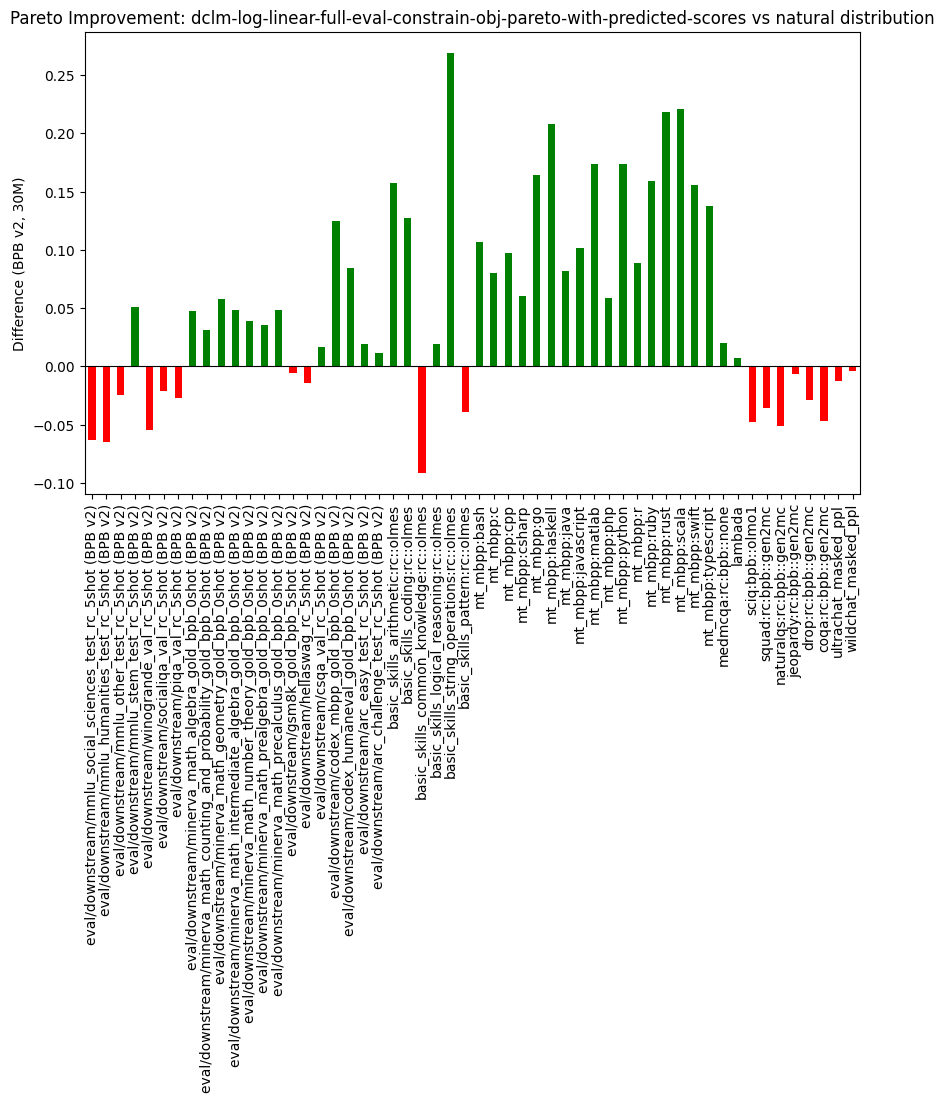

In [140]:
import pandas as pd
import matplotlib.pyplot as plt

# Load your DataFrame (assuming it's already in a variable called `metrics`)
# Example setup:
# metrics = pd.read_csv('your_file.csv') or metrics = ...

# Step 1: Identify the reference and target model
reference_name = 'olmo-cookbook-core-v2-1bv2-5xC-dclm-baseline-topic-classified-sample-natural-28f8e9a9'  # adjust as needed
target_name = 'dclm-1b-log-linear-full-eval-corr-weighting-constrain-obj-pareto-with-predicted-scores-b9e80c0a'

# Step 2: Set index for easy lookup
metrics_indexed = metrics.set_index('name')

# Step 3: Get task columns (excluding name or metadata)
task_columns = metrics.columns[3:57]

# Step 4: Compute differences
reference = metrics_indexed.loc[reference_name, task_columns]
target = metrics_indexed.loc[target_name, task_columns]
diff =  reference - target 

print(diff.max(), diff.min(), diff.mean(), np.where(diff < 0)[0].shape[0])

# Step 5: Plot
colors = ['green' if val > 0 else 'red' for val in diff]
plt.figure(figsize=(10, 6))
diff.plot(kind='bar', color=colors)
plt.title(f'Pareto Improvement: dclm-log-linear-full-eval-constrain-obj-pareto-with-predicted-scores vs natural distribution')
plt.ylabel('Difference (BPB v2, 30M)')
plt.axhline(0, color='black', linewidth=0.8)
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


0.26186450241133286 -0.14824428758873498 0.038578798037705905 19


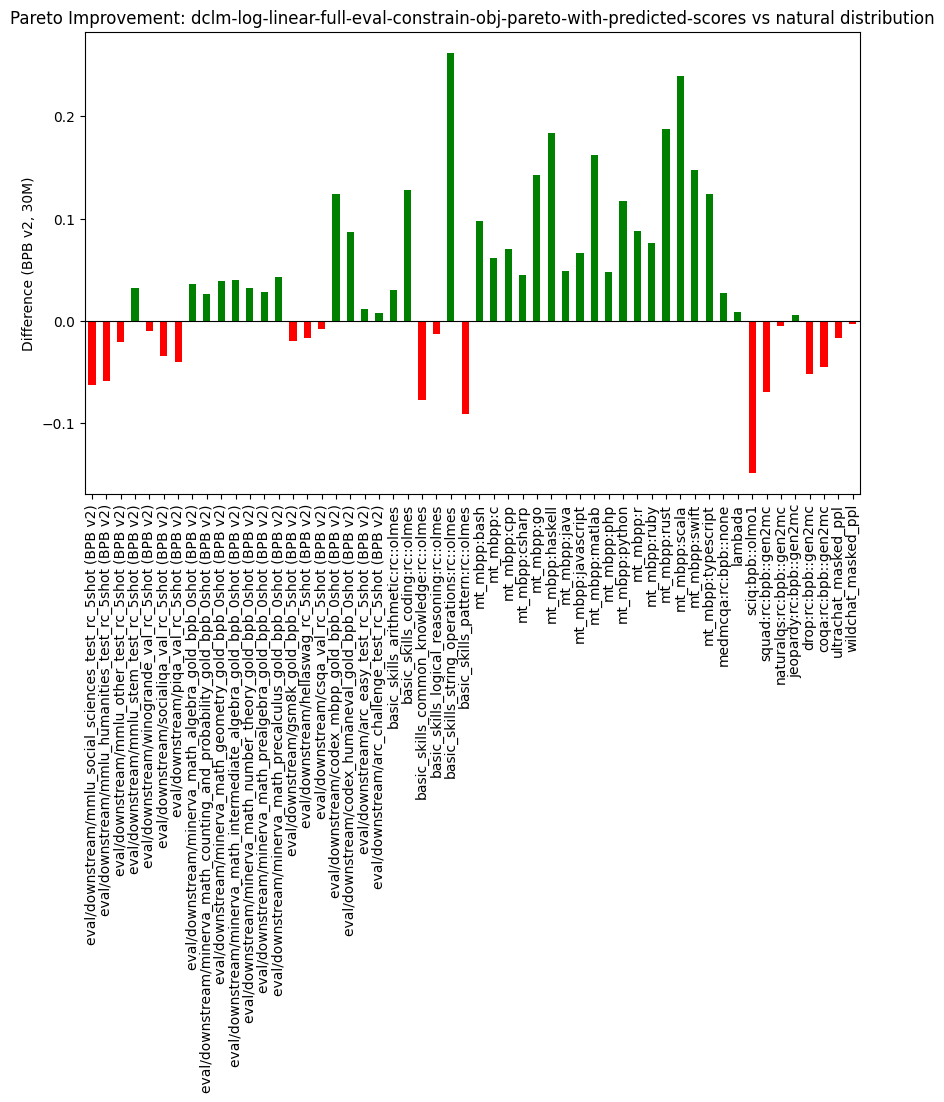

In [141]:
import pandas as pd
import matplotlib.pyplot as plt

# Load your DataFrame (assuming it's already in a variable called `metrics`)
# Example setup:
# metrics = pd.read_csv('your_file.csv') or metrics = ...

# Step 1: Identify the reference and target model
reference_name = 'olmo-cookbook-core-v2-1bv2-5xC-dclm-baseline-topic-classified-sample-natural-28f8e9a9'  # adjust as needed
target_name = 'dclm-1b-log-linear-full-eval-corr-weighting-constrain-obj-pareto-with-true-scores-e07ba770'

# Step 2: Set index for easy lookup
metrics_indexed = metrics.set_index('name')

# Step 3: Get task columns (excluding name or metadata)
task_columns = metrics.columns[3:57]

# Step 4: Compute differences
reference = metrics_indexed.loc[reference_name, task_columns]
target = metrics_indexed.loc[target_name, task_columns]
diff =  reference - target 

print(diff.max(), diff.min(), diff.mean(), np.where(diff < 0)[0].shape[0])

# Step 5: Plot
colors = ['green' if val > 0 else 'red' for val in diff]
plt.figure(figsize=(10, 6))
diff.plot(kind='bar', color=colors)
plt.title(f'Pareto Improvement: dclm-log-linear-full-eval-constrain-obj-pareto-with-predicted-scores vs natural distribution')
plt.ylabel('Difference (BPB v2, 30M)')
plt.axhline(0, color='black', linewidth=0.8)
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


0.2090636039316791 -0.03518194033581967 0.05562564942616022 13


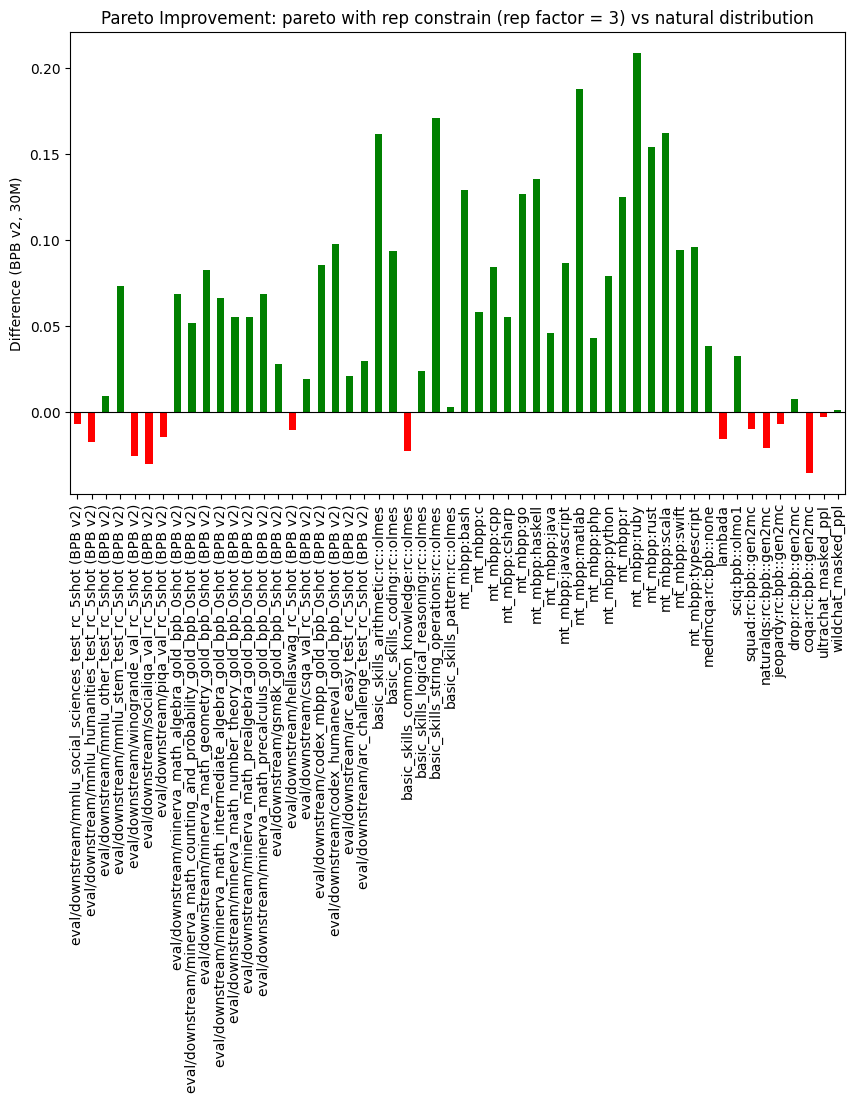

In [190]:
import pandas as pd
import matplotlib.pyplot as plt

# Load your DataFrame (assuming it's already in a variable called `metrics`)
# Example setup:
# metrics = pd.read_csv('your_file.csv') or metrics = ...

# Step 1: Identify the reference and target model
reference_name = 'olmo-cookbook-core-v2-1bv2-5xC-dclm-baseline-topic-classified-sample-natural-28f8e9a9'  # adjust as needed
target_name = 'dclm-1b-log-linear-full-eval-constrain-obj-pareto-with-predicted-scores-357a137e'

# Step 2: Set index for easy lookup
metrics_indexed = metrics.set_index('name')

# Step 3: Get task columns (excluding name or metadata)
task_columns = metrics.columns[3:57]

# Step 4: Compute differences
reference = metrics_indexed.loc[reference_name, task_columns]
target = metrics_indexed.loc[target_name, task_columns]
diff =  reference - target 

print(diff.max(), diff.min(), diff.mean(), np.where(diff < 0)[0].shape[0])

# Step 5: Plot
colors = ['green' if val > 0 else 'red' for val in diff]
plt.figure(figsize=(10, 6))
diff.plot(kind='bar', color=colors)
plt.title(f'Pareto Improvement: pareto with rep constrain (rep factor = 3) vs natural distribution')
plt.ylabel('Difference (BPB v2, 30M)')
plt.axhline(0, color='black', linewidth=0.8)
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


0.16174420727529926 -0.06298495293118056 0.029311432715733856 18


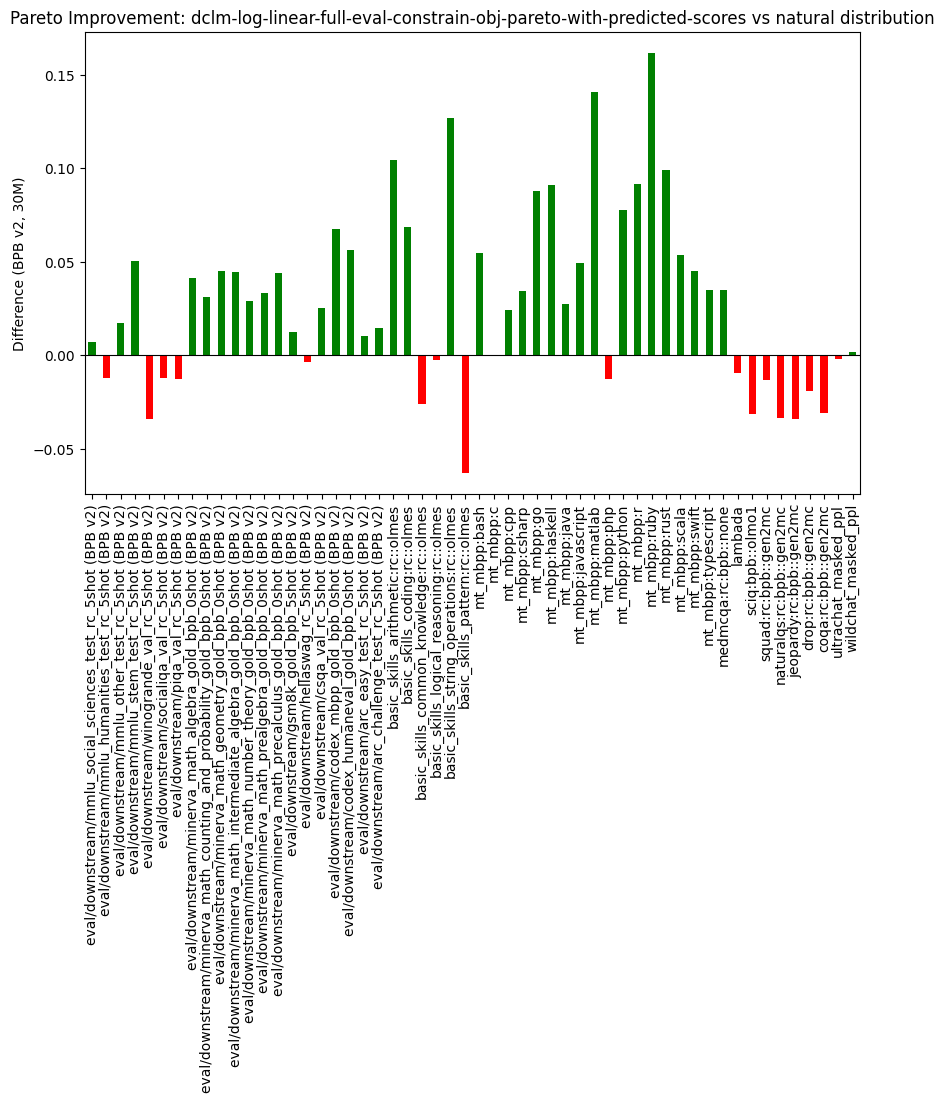

In [143]:
import pandas as pd
import matplotlib.pyplot as plt

# Load your DataFrame (assuming it's already in a variable called `metrics`)
# Example setup:
# metrics = pd.read_csv('your_file.csv') or metrics = ...

# Step 1: Identify the reference and target model
reference_name = 'olmo-cookbook-core-v2-1bv2-5xC-dclm-baseline-topic-classified-sample-natural-28f8e9a9'  # adjust as needed
target_name = 'dclm-1b-log-linear-full-eval-constrain-obj-pareto-with-predicted-scores-d7eaca81'

# Step 2: Set index for easy lookup
metrics_indexed = metrics.set_index('name')

# Step 3: Get task columns (excluding name or metadata)
task_columns = metrics.columns[3:57]

# Step 4: Compute differences
reference = metrics_indexed.loc[reference_name, task_columns]
target = metrics_indexed.loc[target_name, task_columns]
diff =  reference - target 

print(diff.max(), diff.min(), diff.mean(), np.where(diff < 0)[0].shape[0])

# Step 5: Plot
colors = ['green' if val > 0 else 'red' for val in diff]
plt.figure(figsize=(10, 6))
diff.plot(kind='bar', color=colors)
plt.title(f'Pareto Improvement: dclm-log-linear-full-eval-constrain-obj-pareto-with-predicted-scores vs natural distribution')
plt.ylabel('Difference (BPB v2, 30M)')
plt.axhline(0, color='black', linewidth=0.8)
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()
